Style transfer using **VGG features**. Original version of this notebook can be found on [Udacity's Deep Learning Course](https://github.com/udacity/deep-learning-v2-pytorch)

In [0]:
import os
import urllib

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [0]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vgg.to(device)  

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
  
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
    
  if shape:
    size = shape
    
  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
  # Adding batch dimension
  image = in_transform(image)[:3, :, :].unsqueeze(0)
  
  return image

In [26]:
from google.colab import files
a = files.upload()

Saving stars.jpg to stars.jpg


In [0]:
content = load_image("me.jpg").to(device)
style = load_image("stars.jpg", shape=content.shape[-2:]).to(device)

In [0]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0, 1)
  return image

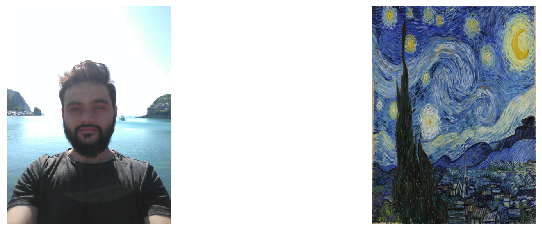

In [29]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(im_convert(content))

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(im_convert(style))
plt.show()

In [0]:
def get_features(image, model, layers=None):
  if layers is None:
    layers = {'0':  "conv1_1",
              '5':  "conv2_1",
              '10': "conv3_1",
              "19": "conv4_1",
              "21": "conv4_2",
              "28": "conv5_1"}
    
  features = {}
  x = image
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x
      
  return features

In [0]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
conv1 = content_features['conv1_1'].cpu().numpy().squeeze()

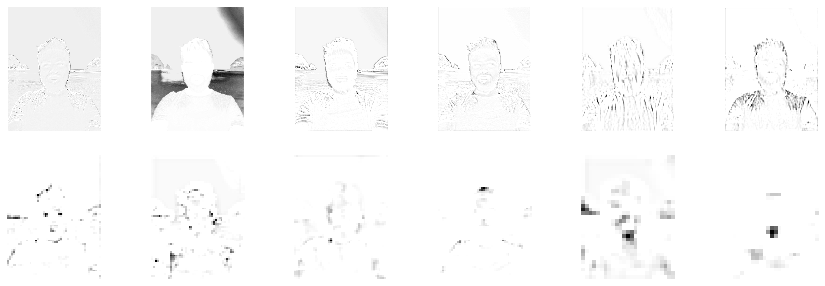

In [12]:
# Display two random feature from every layer.
fig = plt.figure(figsize=(15, 5))
count = 0
for layer, features in content_features.items():
  feats = features.cpu().numpy().squeeze()
  
  for i in range(2):
    ax = fig.add_subplot(2, 6, count+1, xticks=[], yticks=[])
    idx = np.random.randint(0, feats.shape[0]) # Generate random idx between 0 and number of filters.
    ax.imshow(feats[idx, :, :]);
    count += 1

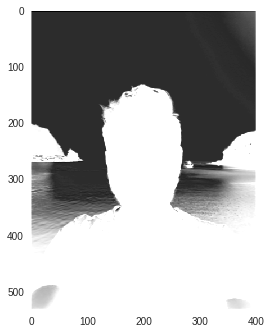

In [13]:
plt.imshow(conv1[0]);
plt.grid(False)

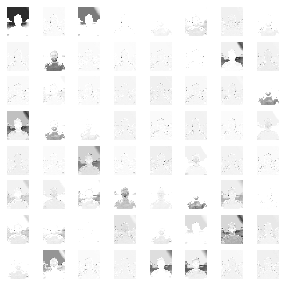

In [14]:
# Only the first Conv Layer.
fig = plt.figure(figsize=(5, 5))

for i in range(64):
  ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
  ax.imshow(conv1[i, :, :]);

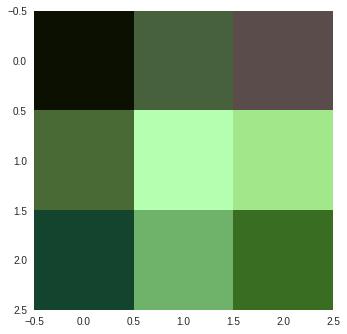

In [17]:
params = next(vgg.parameters())

min_v = torch.min(params[0])
range_v = torch.max(params[0]) - min_v

if range_v > 0:
  normalised = (params[0] - min_v) / range_v
else:
  normalised = torch.zeros(params[0].size())

plt.imshow(normalised.cpu().numpy())
plt.grid(False)

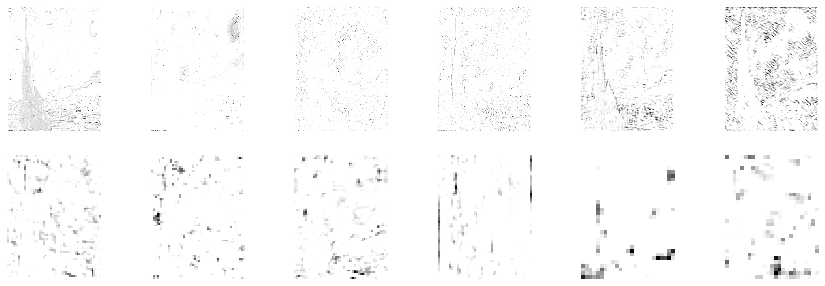

In [31]:
fig = plt.figure(figsize=(15, 5))
count = 0
for layer, features in style_features.items():
  feats = features.cpu().numpy().squeeze()
  
  for i in range(2):
    ax = fig.add_subplot(2, 6, count+1, xticks=[], yticks=[])
    idx = np.random.randint(0, feats.shape[0]) # Generate random idx between 0 and number of filters.
    ax.imshow(feats[idx, :, :]);
    count += 1

In [0]:
style_grams = {layer: gram_matrix(feature) for layer, feature in style_features.items()}
target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {"conv1_1": 1.,
                 "conv2_1": 0.5,
                 "conv3_1": 0.5,
                 "conv4_1": 0.5,
                 "conv5_1": 0.5}

content_weight = 1
style_weight = 1e6

Total loss:  334586.53125


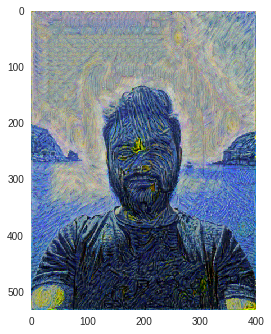

Total loss:  306420.09375


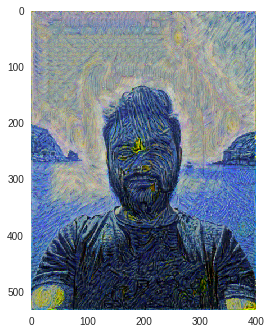

Total loss:  281038.4375


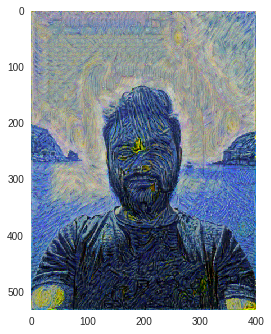

Total loss:  258203.09375


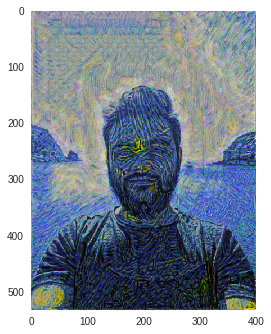

Total loss:  237672.546875


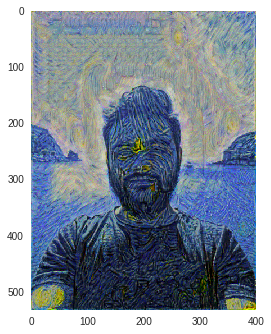

Total loss:  218799.8125


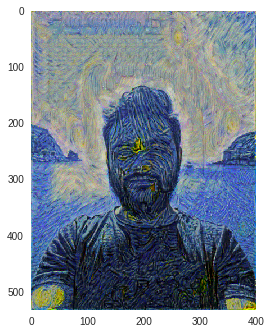

Total loss:  202193.171875


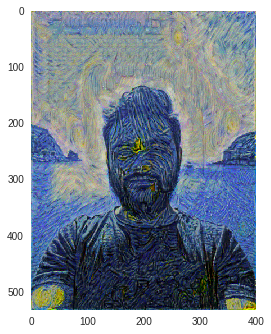

Total loss:  186428.03125


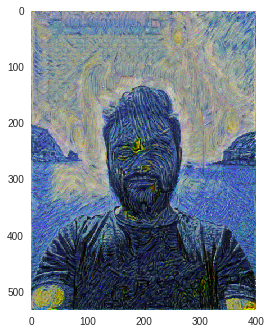

Total loss:  173032.40625


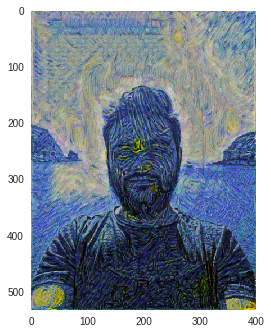

Total loss:  160188.265625


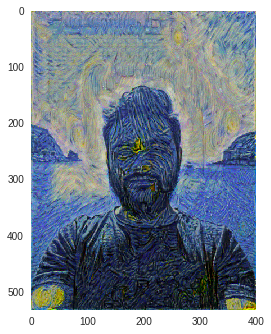

Total loss:  149083.03125


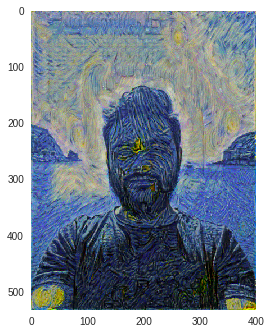

Total loss:  138425.515625


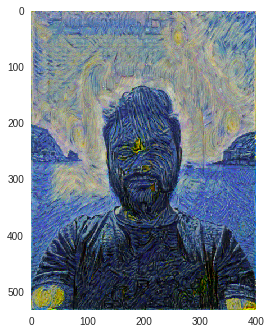

Total loss:  129569.796875


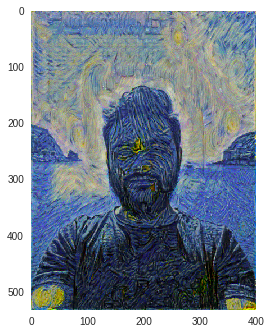

Total loss:  121656.46875


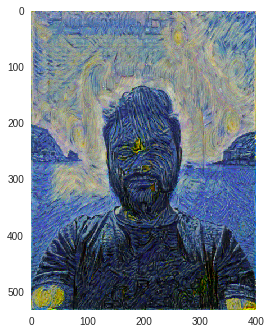

Total loss:  113823.5859375


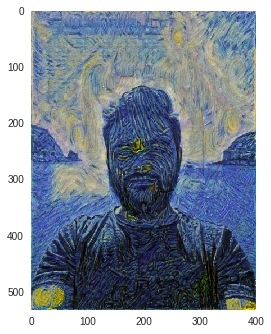

In [39]:
show_every = 200
#optimizer = optim.Adam([target], lr=0.003)
steps = 3000

for i in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
  
  style_loss = 0
  for layer, weight in style_weights.items():
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    
    style_gram = style_grams[layer]
    layer_style_loss = weight * torch.mean((target_gram - style_gram) ** 2)
    style_loss += layer_style_loss / (d * h * w) # Normalizing the style loss
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if i % show_every == 0:
    print("Total loss: ", total_loss.item())
    plt.imshow(im_convert(target))
    plt.grid(False)
    plt.show()

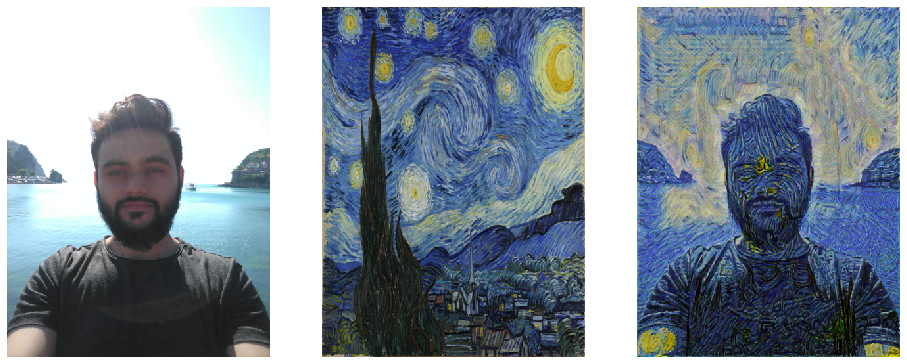

In [43]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.imshow(im_convert(content))

ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.imshow(im_convert(style))

ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.imshow(im_convert(target))
plt.show()